여기는 "파이썬 머신러닝 완벽 가이드" 책을 보면서 몰랐던 부분을 적는 장소 입니다.

# 1. 교차검증

## stratified K 폴드

이 분류는 target data가 한쪽으로 엄청나게 치우쳐져 있을 때 K폴드 대신 사용하게 됩니다. 

이 교차 검증을 사용하는 이유는 일반적인 K폴드를 사용하면 target data가 너무 작은 비율로 분류되서 모델을 학습시키기 어렵기 때문입니다. 

데이터의 분포를 반영해서 임의의 데이터를 만듭니다.

In [105]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

import pandas as pd 
import numpy as np

iris = load_iris()
features = iris.data
target = iris.target
lr_clf= DecisionTreeClassifier(random_state=156)


skf = StratifiedKFold(n_splits=3)
accuracy_list = []

for train_index, test_index in skf.split(features, target):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = target[train_index], target[test_index]
    
    lr_clf.fit(X_train, y_train)
    pred = lr_clf.predict(X_test)
    
    accuracy_list.append(accuracy_score(y_test, pred))

print(accuracy_list)
print(np.mean(accuracy_list))

[0.98, 0.94, 0.98]
0.9666666666666667


# 2. 데이터 전처리

## 레이블 인코딩
숫자형 데이터가 아닌 범주형데이터의 경우에 범주형데이터를 0 1 2 3 ... 으로 대응시키는 방법

하지만 저 숫자들이 대소를 나타내는 것은 아니기 때문에 <b>one-hot encoding</b> 을 해줘야 한다.

In [106]:
from sklearn.preprocessing import LabelEncoder

items = ['TV', '냉장고', '세탁기', '청소기', '시계']

encoder = LabelEncoder()
encoder.fit(items)
labels = encoder.transform(items)
print(labels)
print(encoder.classes_)

[0 1 2 4 3]
['TV' '냉장고' '세탁기' '시계' '청소기']


# 타이타닉 생존자 예측(데이터 전처리 실습) 

In [107]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

titanic_df = pd.read_csv('datasets/titanic_train.csv')

# 결손 데이터 처리
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)

# Cabin 데이터에서 방의 등급만 추출
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]


# 데이터를 원핫인코딩함
titanic_df = pd.get_dummies(data = titanic_df, columns = ['Sex', 'Embarked', 'Cabin'])
        
# 영향이 미미한 피처는 삭제
titanic_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

# X, y 나누기
y = titanic_df['Survived']
X = titanic_df.drop(['Survived'], axis=1)

# test, train 나누기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

# 로지스틱회귀모델을 사용
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)

print('Logistic 모델 정확도: {0:.4f}'.format(accuracy_score(lr_clf.predict(X_test), y_test)))

# K-fold 교차검증
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5)
scores = []
for (train_index, test_index) in (kfold.split(X)):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    lr_clf.fit(X_train,y_train)
    score = accuracy_score(lr_clf.predict(X_test),y_test)
    scores.append(score)
print("5겹 교차검증 평균 모델정확도: {0:.4f}".format(np.mean(scores)))

# cross_val_score를 이용해서 검증 (stratifiedKFold를 이용함.)
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr_clf, X, y, cv=5)
print("cross_val_score 평균 모델 정확도: {0:.4f}".format(np.mean(scores)))


Logistic 모델 정확도: 0.8492
5겹 교차검증 평균 모델정확도: 0.7935
cross_val_score 평균 모델 정확도: 0.7946


# 3. 머신러닝 모델 평가 

accuracy_score를 이용한 단순한 정확도 계산은 피처를 제대로 이용하지 않았을 때와 효율적인 피처이용을 했을 때의 정확도를 같게 측정할 수 도 있다.

그래서 <b>오차행렬</b> 이란것을 사용한다. 오차행렬은 4분면으로 구성되어 있다.
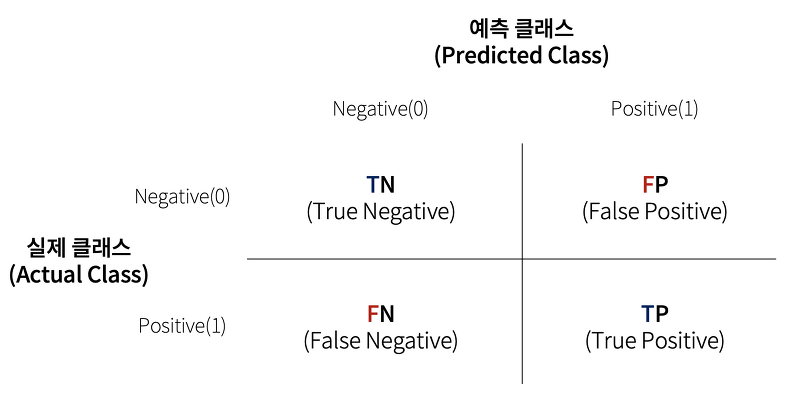
위 사분면을 이해하기 쉽게 생각해보자면 모델로 예측한 데이터에서의 P/N 과 실제 데이터의 T/F를 나타낸 것이다. <br>
참고로 실제데이터 부터 적는다.

#### 정확도 : (TN+NF) / (TN+FP+FN+TP)
하지만 불균형한 데이터로 학습시키는 경우 TN이 커지고 TP는 매우 작아져서 실제와 다르게 정확도가 높게 나올 수 있다.

그래서 정밀도와 재현율이 선호되는 지표이다.

#### 정밀도 = TP / (FP+TP) : 예측을 positive로 한 대상 중에 예측이 실제 값이 Positive로 일치한 데이터의 비율
정밀도는 실제 Negative인 데이터를 Positive로 잘못 판단하면 안되는 경우에 중요함.

#### 재현율 = TP / (FN+TP) : 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
재현율은 실제 Positive인 데이터를 Negative로 잘못 판단하면 안되는 경우에 중요함. 

In [108]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval1(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {}, 재현율: {}, 정밀도: {}'.format(round(accuracy,4), round(precision,4), round(recall,4)))
    print('\n')

get_clf_eval(lr_clf.predict(X_test), y_test)

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## 사이킷런 개별데이터 예측확률 /  predict_proba(data)
예를 들어 이진 분류 모델에서는 데이터가 T일 확률과 F일 확률 중 큰 값으로 정하게함.

In [109]:
pred_proba = lr_clf.predict_proba(X_test)
print("앞 3개만 샘플로 추출: ")
print(pred_proba[:3])
print("\n앞 3개중 더 큰 확률을 클래스 값으로 예측: ")
print(lr_clf.predict(X_test)[:3])

앞 3개만 샘플로 추출: 
[[0.89026387 0.10973613]
 [0.88067241 0.11932759]
 [0.63808423 0.36191577]]

앞 3개중 더 큰 확률을 클래스 값으로 예측: 
[0 0 0]


# Binarizer 클래스 | 정밀도/재현율 트레이드

In [110]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]
# X의 개별 원소들이 threshold 값보다 작거나 같으면 0을, 크면 1을 반환함
binarizer = Binarizer(threshold=1.1)
binarizer.fit_transform(X)

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

# Binarizer를 이용한 predict()의 의사코드 만들기

In [117]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정 값. 분류 결정 임계값임.
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해서 Binarizer를 
pred_proba_1 = pred_proba[:, 1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval1(y_test, custom_predict)
print(pred_proba[:, 1])
pred_proba_1

오차행렬
[[102  13]
 [ 17  46]]
정확도: 0.8315, 재현율: 0.7797, 정밀도: 0.7302


[0.10973613 0.11932759 0.36191577 0.92745015 0.91697226 0.14268989
 0.09861076 0.8602686  0.11901637 0.18554437 0.12552912 0.59525567
 0.13758469 0.62718509 0.69061352 0.191645   0.59456875 0.95780011
 0.21820867 0.20030278 0.23835845 0.23835845 0.1126374  0.3247363
 0.78433711 0.10743617 0.10743617 0.61483225 0.29544221 0.94814348
 0.10124805 0.1038941  0.19607897 0.10780257 0.77727635 0.6409226
 0.13608906 0.83249938 0.37239986 0.09895719 0.12743567 0.56410714
 0.28226946 0.11220831 0.26488048 0.09612841 0.93849398 0.10887318
 0.07979389 0.17335933 0.89325037 0.15160916 0.91095594 0.43346349
 0.68565836 0.11682324 0.10132707 0.1246546  0.06626273 0.82287138
 0.13681641 0.45503777 0.14432489 0.36152475 0.77201407 0.14056113
 0.92742936 0.77793699 0.94640416 0.6196001  0.06465517 0.12094999
 0.12099797 0.69703726 0.09085268 0.13588403 0.49912919 0.14056454
 0.28286132 0.15459867 0.4285375  0.121153   0.16471508 0.92518

array([[0.10973613],
       [0.11932759],
       [0.36191577],
       [0.92745015],
       [0.91697226],
       [0.14268989],
       [0.09861076],
       [0.8602686 ],
       [0.11901637],
       [0.18554437],
       [0.12552912],
       [0.59525567],
       [0.13758469],
       [0.62718509],
       [0.69061352],
       [0.191645  ],
       [0.59456875],
       [0.95780011],
       [0.21820867],
       [0.20030278],
       [0.23835845],
       [0.23835845],
       [0.1126374 ],
       [0.3247363 ],
       [0.78433711],
       [0.10743617],
       [0.10743617],
       [0.61483225],
       [0.29544221],
       [0.94814348],
       [0.10124805],
       [0.1038941 ],
       [0.19607897],
       [0.10780257],
       [0.77727635],
       [0.6409226 ],
       [0.13608906],
       [0.83249938],
       [0.37239986],
       [0.09895719],
       [0.12743567],
       [0.56410714],
       [0.28226946],
       [0.11220831],
       [0.26488048],
       [0.09612841],
       [0.93849398],
       [0.108

In [78]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정 값. 분류 결정 임계값임.
custom_threshold = 0.4

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해서 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[80 20]
 [17 37]]
정확도: 0.7597, 재현율: 0.6491, 정밀도: 0.6852




### 임계값을 낮추니 재현율이 내려가고 정밀도가 올라감.
왜냐하면 임계값이 내려갈수록 True 가 많아지기 때문이다. 

## 임계값을 바꿔가면서 재현율과 정밀도를 구해보자

In [80]:
# 임계값이 될 값들이 저장된 리스트 생성
thresholds = [0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7]

def get_eval_by_threshold(y_test, pred_proba_c1, threshold_list):
    #threshold list객체 내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in threshold_list:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_pred = binarizer.transform(pred_proba_c1)
        print("임계값: {}".format(custom_threshold))
        get_clf_eval1(y_test, custom_pred)
        
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임계값: 0.3
오차행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 재현율: 0.5658, 정밀도: 0.7963


임계값: 0.4
오차행렬
[[80 20]
 [17 37]]
정확도: 0.7597, 재현율: 0.6491, 정밀도: 0.6852


임계값: 0.45
오차행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 재현율: 0.7059, 정밀도: 0.6667


임계값: 0.5
오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 재현율: 0.7674, 정밀도: 0.6111


임계값: 0.55
오차행렬
[[91  9]
 [23 31]]
정확도: 0.7922, 재현율: 0.775, 정밀도: 0.5741


임계값: 0.6
오차행렬
[[91  9]
 [26 28]]
정확도: 0.7727, 재현율: 0.7568, 정밀도: 0.5185


임계값: 0.7
오차행렬
[[96  4]
 [28 26]]
정확도: 0.7922, 재현율: 0.8667, 정밀도: 0.4815




## 방금 만든 코드와 유사한 sklearn api <br>| precision_recall_curve(실제 클래스값 배열, Positive 칼럼의 예측 확률 배열)


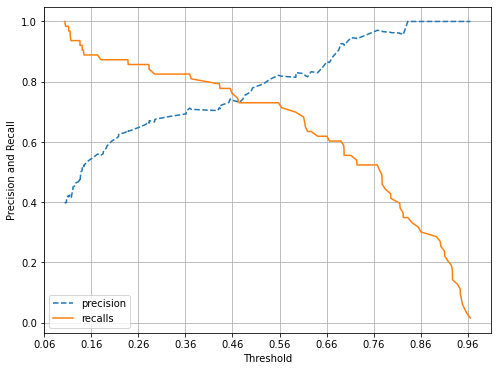

In [59]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
    
def precision_recall_curve_plot(y_test, pred_prova_c1):
    # Positive 칼럼의 예측 확률 배열
    pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

    # precision_recall_curve 함수 사용, 리턴값 3개 (정밀도, 재현율, 임계값)
    precisions, recalls, threshold = precision_recall_curve(y_test, pred_proba_class1)

    # X축을 임계값으로, y축은 정밀도, 재현율 값으로 각각 plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = threshold.shape[0]
    plt.plot(threshold, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(threshold, recalls[0:threshold_boundary], label='recalls')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))

    plt.xlabel('Threshold'); plt.ylabel('Precision and Recall')
    plt.legend(); plt.grid()
    plt.show

precision_recall_curve_plot(y_test, pred_proba[:,1].reshape(-1,1))

# F1 스코어
F1 스코어는 정밀도와 재현율을 결합한 지표이다. 
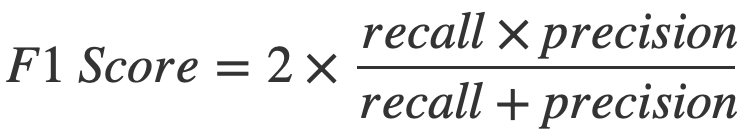

F1 스코어는 보통 높을 수록 좋다.

In [83]:
from sklearn.metrics import f1_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    #f1스코어 추가
    f1 = f1_score(y_test,pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {}, 재현율: {}, 정밀도: {}, f1 스코어: {}'.format(round(accuracy,4), round(precision,4), round(recall,4), round(f1,4)))

    print('\n')

# ROC 곡선과 AUC

## ROC 곡선 : FPR 이 변할 때 TPR이 얼마나 변하는지를 나타내는 곡선
FPR : FP/ (FP + TN) = 1 - TNR(진짜음성을 진짜 음성이라 구분하는 정도), TPR : 재현율

## AUC: ROC 곡선의 면적
1에 가까울 수록 좋음

In [84]:
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬:')
    print(confusion)
    print('\n정확도: {}, 정밀도: {}, 재현율: {}, f1 스코어: {}, AUC: {}'.format(round(accuracy,4), round(precision,4), round(recall,4), round(f1,4), round(roc_auc, 4)))

    print('\n')

# 피마 인디언 당뇨병 예측
https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

data = pd.read_csv('datasets/diabetes.csv')
df = pd.DataFrame(data)


# 로지스틱 모델링
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
#stratify=y 를 하면 target 비율을 맞춰서 나눠줌 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=156, stratify=y)

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
predict = lr_clf.predict(X_test)
predict_proba= lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, predict, predict_proba)

오차행렬:
[[133  17]
 [ 33  48]]

정확도: 0.7835, 정밀도: 0.7385, 재현율: 0.5926, f1 스코어: 0.6575, AUC: 0.8091




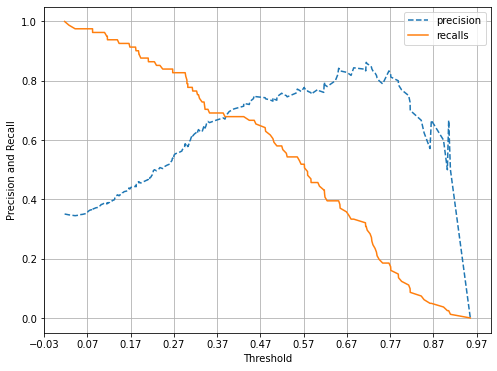

In [86]:
predict_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, predict_proba_c1)

In [87]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


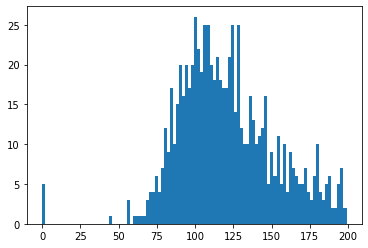

In [88]:
plt.hist(df['Glucose'], bins=100)
plt.show()

In [89]:
# 글루코스가 0인건 말이 안된다. 그러니까 데이터 전처리를 잘 해주자

# 0값을 검사할 feature명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = 768

# 피쳐별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = df[df[feature]==0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


In [90]:
# 0을 각 피처의 평균으로 대체해준다
mean_zero_features = df[zero_features].mean()
df[zero_features]= df[zero_features].replace(0, mean_zero_features)

In [91]:
X = df.iloc[:, : -1]
y = df.iloc[:, -1]

# StandardScaler 클래스를 이용해서 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행.
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬:
[[90 10]
 [21 33]]

정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, f1 스코어: 0.6804, AUC: 0.8433




In [92]:
threshold = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), threshold)

임계값: 0.3
오차행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 재현율: 0.5658, 정밀도: 0.7963


임계값: 0.33
오차행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 재현율: 0.6, 정밀도: 0.7778


임계값: 0.36
오차행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 재현율: 0.619, 정밀도: 0.7222


임계값: 0.39
오차행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 재현율: 0.6333, 정밀도: 0.7037


임계값: 0.42
오차행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 재현율: 0.6923, 정밀도: 0.6667


임계값: 0.45
오차행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 재현율: 0.7059, 정밀도: 0.6667


임계값: 0.48
오차행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 재현율: 0.7447, 정밀도: 0.6481


임계값: 0.5
오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 재현율: 0.7674, 정밀도: 0.6111




# 임계값을 0.48로 정하고 로지스틱 회귀 진행

In [119]:
# 임계값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)
pred_th_48 = binarizer.fit_transform(pred_proba[:,1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_48, pred_proba[:, 1])


오차행렬:
[[99 16]
 [17 46]]

정확도: 0.8146, 정밀도: 0.7419, 재현율: 0.7302, f1 스코어: 0.736, AUC: 0.8826




## 로지스틱회귀 solver를 찾아보다가 읽을 만한 스택오버플로우 링크
https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions